## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [89]:
# 한글 폰트 오류 해결
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)

In [2]:
!pip install yfinance

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [3]:
tsmc = yf.download("TSMC34.SA", start="2021-10-06", end="2024-10-07")

[*********************100%***********************]  1 of 1 completed


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [4]:
tsmc.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [5]:
# 자동으로 시간 순서대로 정렬되어 있으므로 패스
tsmc.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-06,75.099998,75.099998,74.199997,74.970001,71.286835,4997
2021-10-07,76.480003,76.949997,76.150002,76.589996,72.827248,15980
2021-10-08,76.400002,76.489998,75.599998,76.150002,72.408859,103763
2021-10-11,76.139999,77.040001,75.459999,76.480003,72.722649,27863
2021-10-13,76.150002,76.389999,75.320000,75.489998,71.781288,19097
2021-10-14,77.849998,78.940002,76.500000,77.010002,73.226624,23099
2021-10-15,78.699997,79.050003,76.860001,77.989998,74.158470,12205
2021-10-18,78.489998,80.000000,78.250000,80.000000,76.069710,14284
2021-10-19,80.300003,81.919998,80.110001,81.790001,77.771774,20027


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

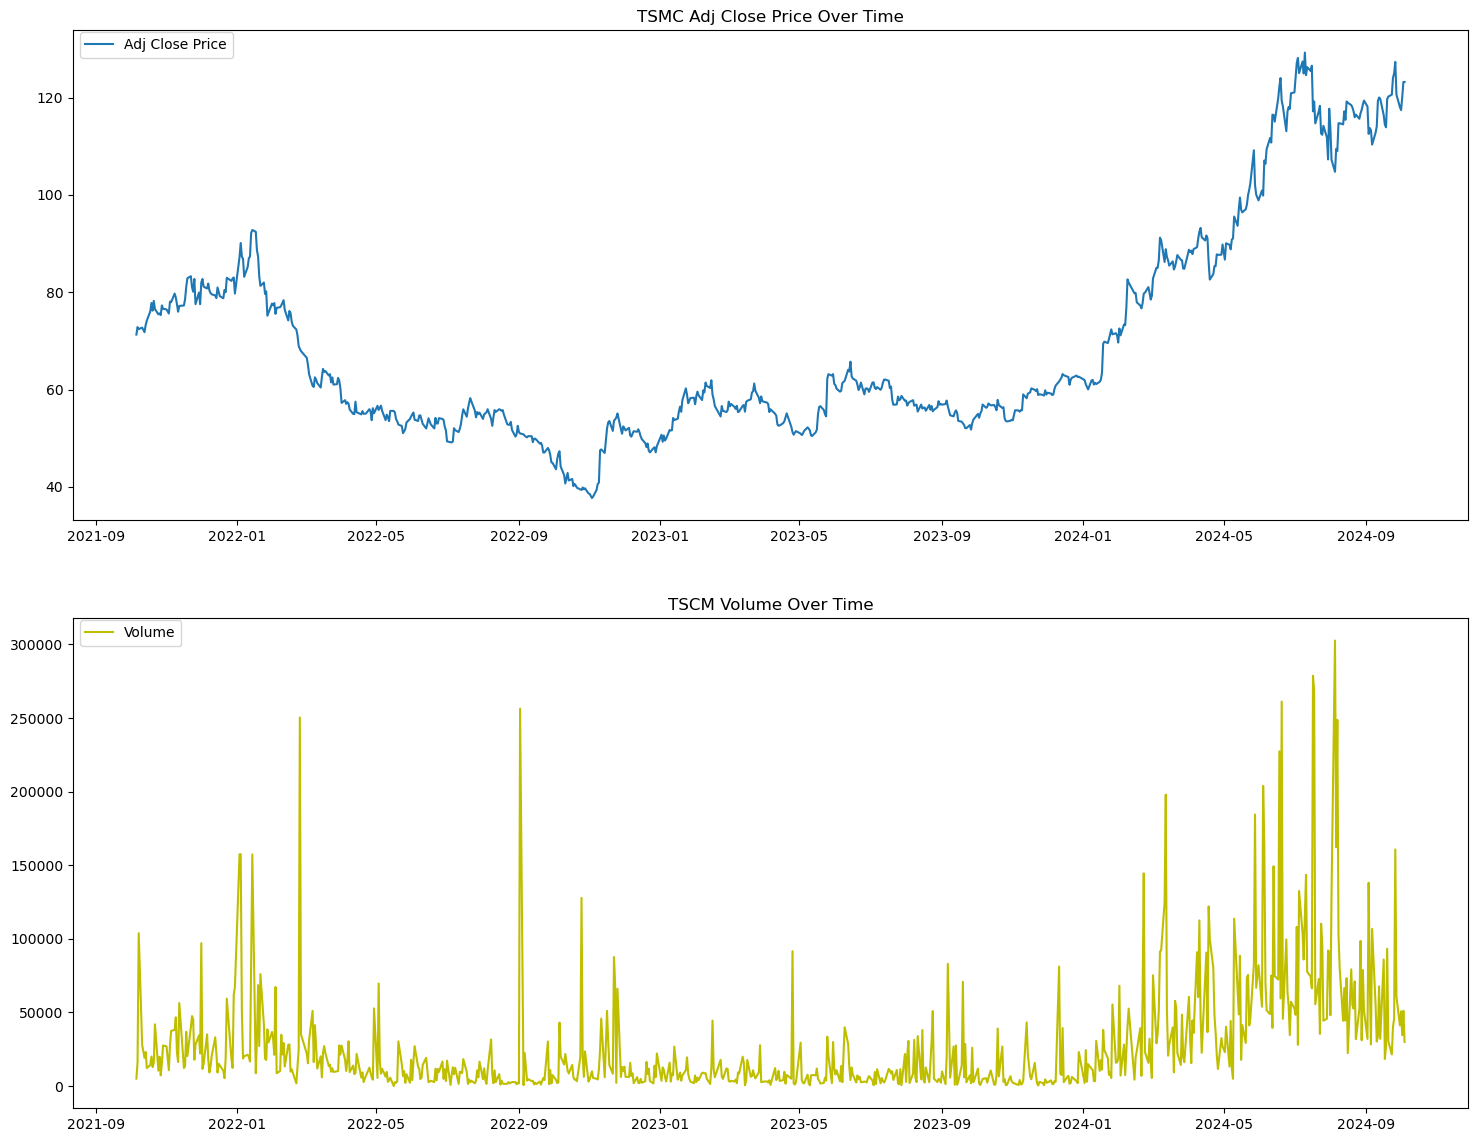

In [8]:
fig = plt.figure(figsize = (18,14))

axes1 = fig.add_subplot(2,1,1)
axes2 = fig.add_subplot(2,1,2)

axes1.plot(tsmc["Adj Close"], "-", label = "Adj Close Price")
axes1.set_title("TSMC Adj Close Price Over Time")
axes1.legend(loc="center left", bbox_to_anchor=(0,0.97))

axes2.plot(tsmc["Volume"], "-", color = "y", label = "Volume")
axes2.set_title("TSCM Volume Over Time")
axes2.legend(loc="center left", bbox_to_anchor=(0,0.97))

plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 2022년부터 2024년 1월까지 TSMC의 약세를 확인할 수 있음
  - 기존에 제공하던 반도체 기술에 공급 과잉 문제가 발생
  - 기술 칩에 대한 수요는 계속해서 증가했지만 이 기술을 따라가지 못해서 부진
  - 그러나 2024년 AI 관련 애플리케이션의 급속한 성장과 3나노미터 칩과 같은 고급 반도체 기술력을 키웠고, 이에 대한 수요가 급증
  - 이에 따라 주가 급부상

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

- "안정되다"라는 뜻을 가진 정 (定)과 "항상"이라는 뜻을 가진 상 (常)의 한자를 가져, "일정하여 늘 한곁같은 성질"을 의미
- 즉, 정상성은 시계열 데이터가 시점에 따라 평균이나 분산 같은 통계적 특징이 변하지 않으며, 추세나 계절성이 없는 시계열 데이터일 때 해당 데이터를 의미

- 정상성이 중요한 이유는 시계열의 평균과 분산이 일정해야 시계열 값을 예측할 수 있기 때문

- 해결 방법으로는 3개가 존재
  - 차분(Differencing)
    - t시점과 t−1시점의 값의 차이를 구하는 것을 의미
    - 2차 차분 및 계절성 차분도 존재
  - 로그 변환, 이를 통해 정상성을 띠지 않는 시계열 자료의 분산을 줄일 수 있음
  - 로그 변환 + 차분 = 로그 차분의미합니다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [48]:
result = adfuller(tsmc["Adj Close"])

print(f'ADF statistics : {result[0]}')
print(f'p-value {result[1]}')

ADF statistics : 0.4076456224098228
p-value 0.9817786193648261


2.3 ADF Test 결과를 해석하세요.

- ADF statistics : 0.407
  - 정상성이 없을 가능성이 매우 큼
- p-value : 0.98(???)
  - 매우 매우 크기 때문에 귀무가설 기각 불가능, 즉 비정상적이라 결론

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

- ACF(Auto Correlation Function), 시차에 따른 일련의 자기상관을 나타낸 자기상관함수
  - 시차에 따른 관측값 간의 연관 정도를 보여주며, 시차가 커질수록 ACF는 점차 0에 가까워짐
  -  시계열의 정상성을 평가할 때 유용
    - 정상 시계열의 경우 ACF는 상대적으로 빨리 0(상관관계가 0)으로 접근
    - 비정상 시계열의 경우 ACF는 천천히 감소하며 종종 큰 양의 값을 가짐

- PACF(Partial Auto Correlation Function), 시차에 따른 일련의 편자기 상관을 나타낸 편자기 상관함수
  - 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성을 나타냄

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

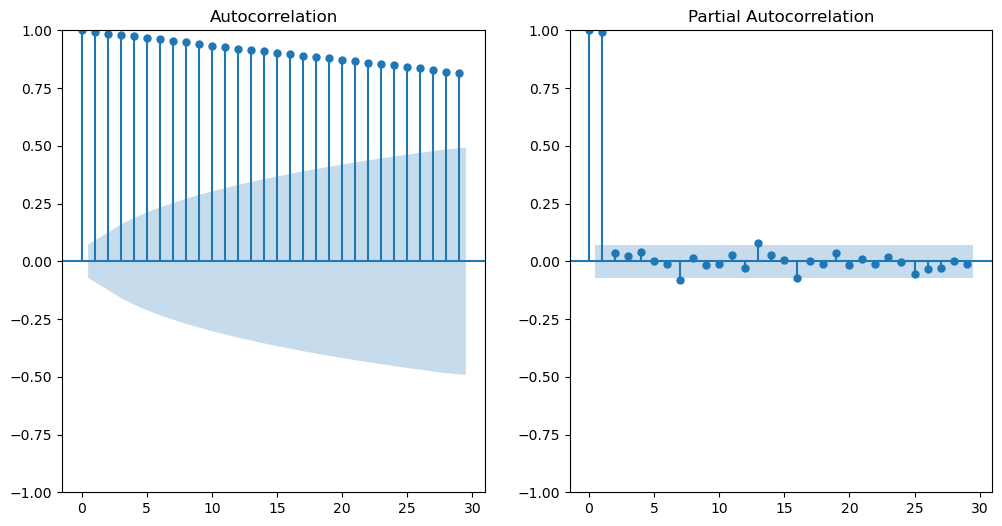

In [10]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

plot_acf(tsmc["Adj Close"], ax = axes[0])
plot_pacf(tsmc["Adj Close"], ax = axes[1])
plt.show()

2.6 결과를 해석하세요.

- acf의 경우 1차부터 30차까지 전부 다 신뢰구간 영역에 들어가지 못함
  - 즉, 종가 데이터는 자기상관성을 띔 = 비정상적인 데이터
  - 시간에 따라 변화하는 트렌드 및 계절성이 존재한다고 판단

- pacf의 경우 1번 째 이후 파란색 박스에 들어가므로, AR(1)모델을 적용해야 함을 암시

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

In [11]:
tsmc.reset_index(inplace=True)
tsmc = tsmc[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

In [12]:
tsmc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-06,75.099998,75.099998,74.199997,74.970001,71.286835,4997
1,2021-10-07,76.480003,76.949997,76.150002,76.589996,72.827248,15980
2,2021-10-08,76.400002,76.489998,75.599998,76.150002,72.408859,103763
3,2021-10-11,76.139999,77.040001,75.459999,76.480003,72.722649,27863
4,2021-10-13,76.150002,76.389999,75.320000,75.489998,71.781288,19097


In [13]:
tsmc.set_index(tsmc["Date"], drop = True, inplace = True)
result = seasonal_decompose(tsmc["Adj Close"], model = "additive", period = 365)

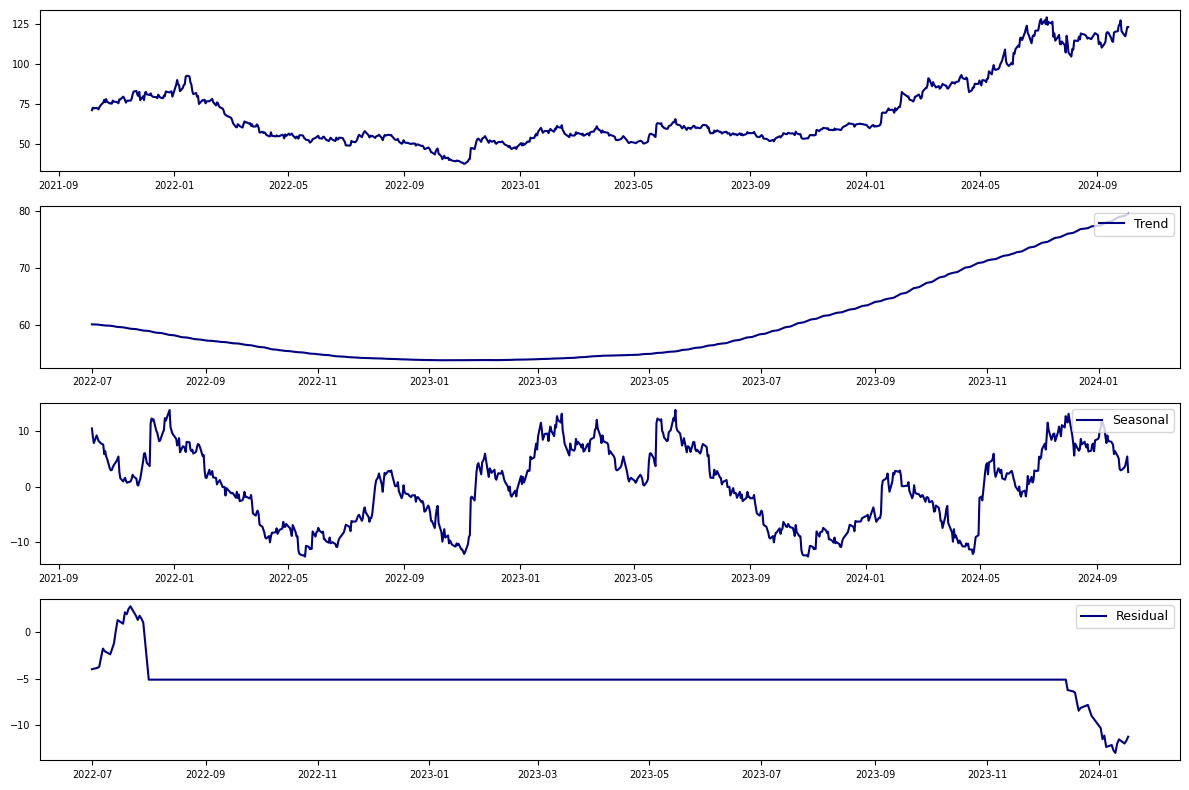

In [38]:
# 결과 시각화
plt.figure(figsize=(12,8))

# 원본 데이터 플롯
plt.subplot(4, 1, 1)
plt.plot(tsmc["Adj Close"], label = 'original',color='navy')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 추세 플롯
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 계절성 플롯
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 잔차 플롯
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

2.8 위 결과를 해석하세요.

- 종가 오리지널의 경우 2024년 1월까지는 하락 및 작은 반등과 하락을 반복하다가 이후부터 올라가기 시작
  
- 추세(Trend)의 경우 2023년 3월까지 하락하다가 이후부터 상승하는 경향을 보임
  
- 계절성(Seasonal)의 경우 하락과 상승을 4~5개월 단위로 반복하는 패턴이 확인됨
  - 명백한 주기성이 보이므로, 계절성 요인이 시계열 데이터에 강하게 작용하고 있음

- 잔차(Residual)의 경우 2022년 8월까지 변동이 있다가 이후부터는 평평
  - 평평한 부분의 경우 추세와 계절성을 제거하고 남은 불규칙성이 상대적으로 적음을 의미

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

- 차분(Differencing)
    - t시점과 t−1시점의 값의 차이를 구하는 것을 의미
    - 2차 차분 및 계절성 차분도 존재

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [49]:
# 1차 ㅊ차분
adj_diff = tsmc["Adj Close"].diff()

In [50]:
result = adfuller(adj_diff.dropna())

print(f'ADF statistics : {result[0]}')
print(f'p-value {result[1]}')

ADF statistics : -29.9746469145139
p-value 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

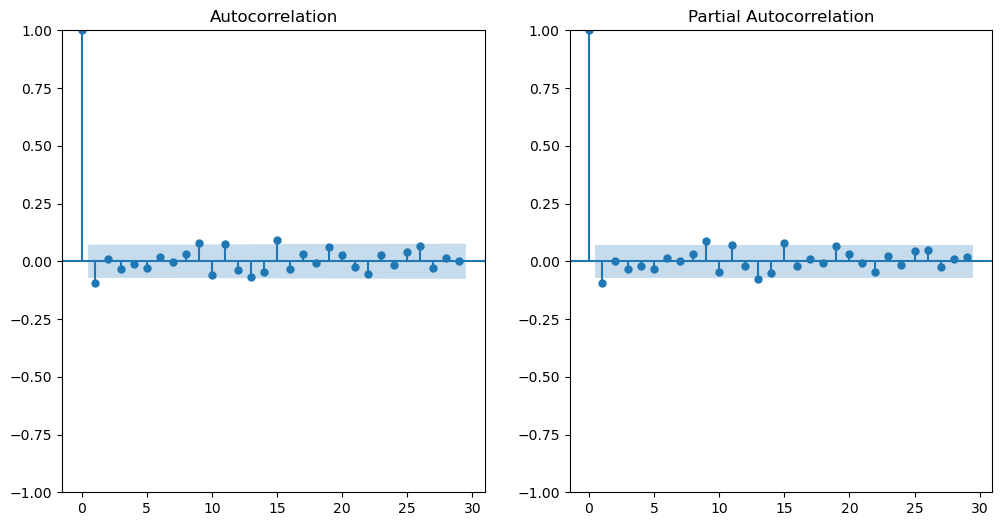

In [51]:
# ACF, PACF 그래프
fig, axes = plt.subplots(1,2, figsize = (12,6))

plot_acf(adj_diff.dropna(), ax = axes[0])
plot_pacf(adj_diff.dropna(), ax = axes[1])
plt.show()

In [54]:
# 1차 차분한 데이터에 seasonal_decompose 적용
result = seasonal_decompose(adj_diff.dropna(), model = "additive", period = 365)

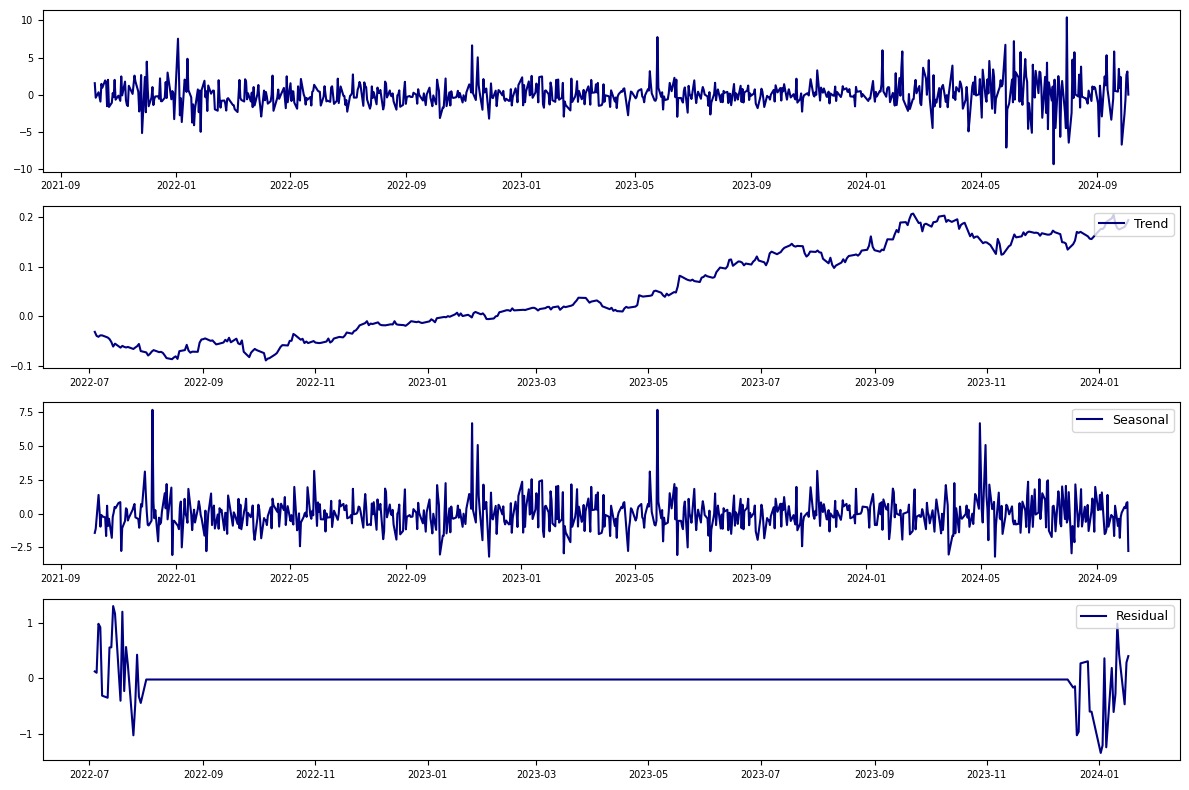

In [55]:
# seasonal_decompose 그래프
# 결과 시각화
plt.figure(figsize=(12,8))

# 원본 데이터 플롯
plt.subplot(4, 1, 1)
plt.plot(adj_diff.dropna(), label = 'original',color='navy')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 추세 플롯
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 계절성 플롯
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 잔차 플롯
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='navy')
plt.legend(loc='upper right',fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

# LSTM으로 분석하기

## 데이터 로드 및 시각화

In [56]:
nvda = yf.download("NVDA", start = "2021-10-01", end = "2024-10-07")
nvda.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-01,20.750000,20.858999,20.202999,20.742001,20.706451,240978000
2021-10-04,20.504000,20.542000,19.555000,19.732000,19.698181,345635000
2021-10-05,19.950001,20.648001,19.854000,20.451000,20.415951,279282000
2021-10-06,20.120001,20.719999,20.080000,20.700001,20.664524,297202000
2021-10-07,21.091999,21.322001,20.972000,21.075001,21.038881,256919000


In [57]:
nvda.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

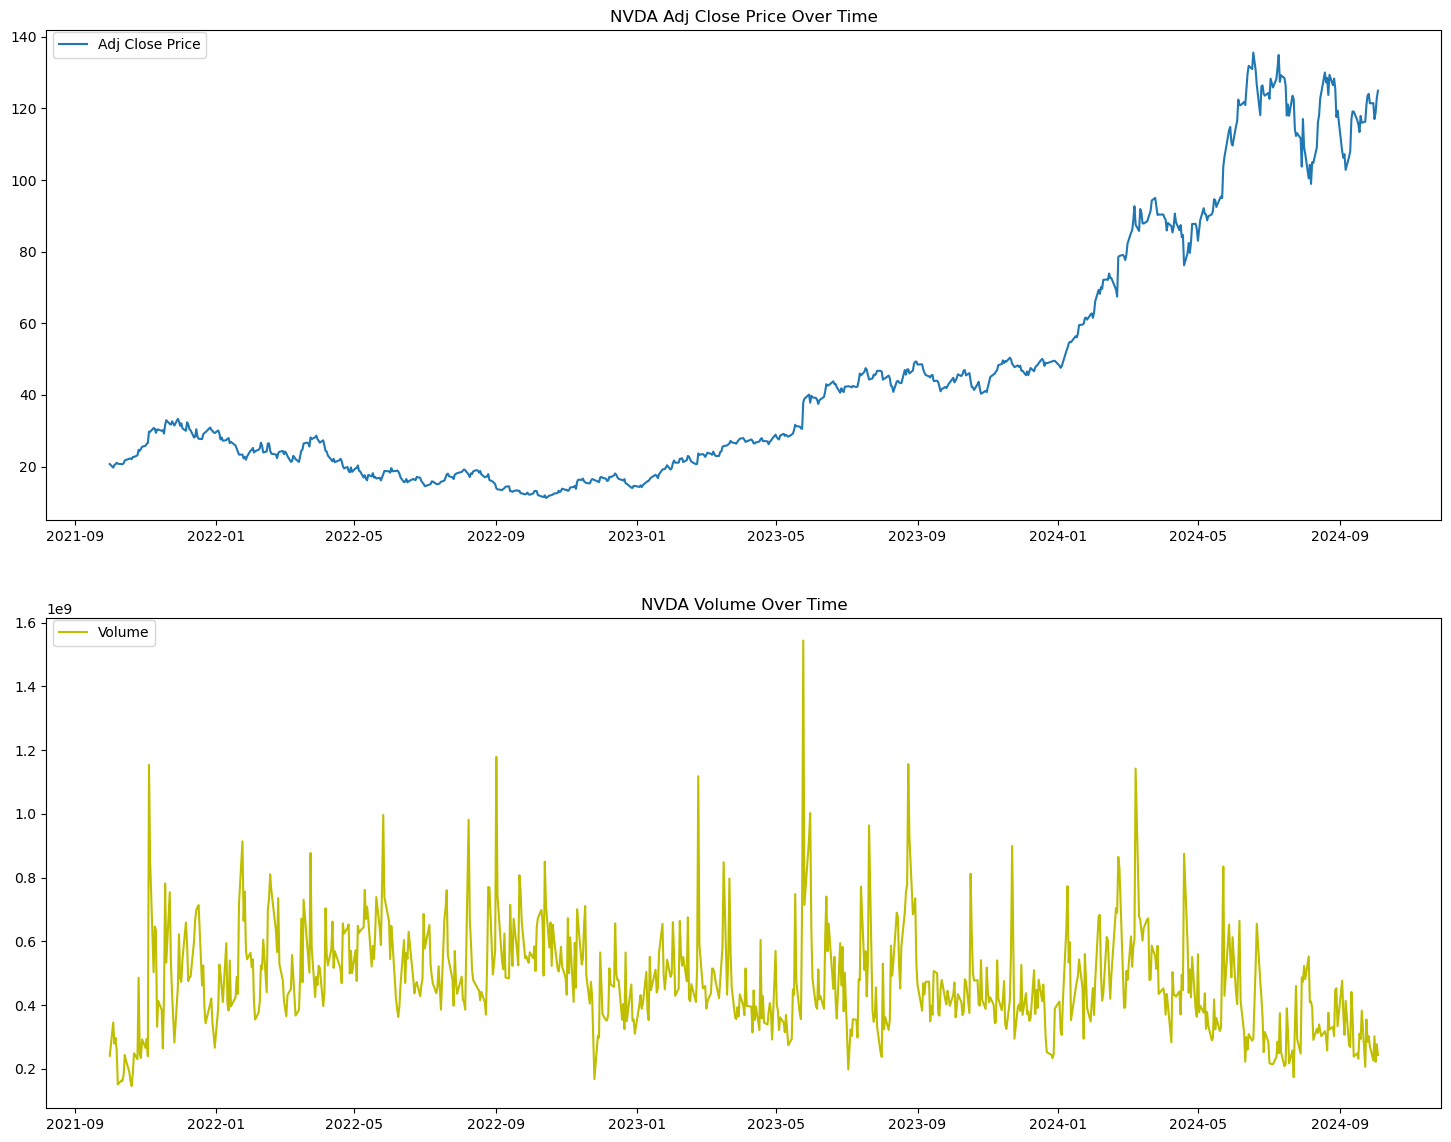

In [60]:
fig = plt.figure(figsize = (18,14))

axes1 = fig.add_subplot(2,1,1)
axes2 = fig.add_subplot(2,1,2)

axes1.plot(nvda["Adj Close"], "-", label = "Adj Close Price")
axes1.set_title("NVDA Adj Close Price Over Time")
axes1.legend(loc="center left", bbox_to_anchor=(0,0.97))

axes2.plot(nvda["Volume"], "-", color = "y", label = "Volume")
axes2.set_title("NVDA Volume Over Time")
axes2.legend(loc="center left", bbox_to_anchor=(0,0.97))

plt.show()

## LSTM 준비하기

### 데이터 준비 및 전처리

In [74]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM

- 왜 정상화 및 차분화를 할 필요가 없는지
  - LSTM자체가 복잡한 패턴 학습에 알맞는 딥러닝 방식이기 때문

In [63]:
# 데이터 스케일링
scaler = MinMaxScaler()

In [65]:
scaled_adj = scaler.fit_transform(nvda["Adj Close"].values.reshape(-1,1))

In [67]:
# 훈련 데이터셋 만들기
time_step = 90

In [69]:
x, y = [], []

for i in range(len(scaled_adj) - time_step -1):
    x.append(scaled_adj[i : (i + time_step), 0])
    y.append(scaled_adj[i + time_step, 0])

In [70]:
x = np.array(x)
y = np.array(y)

In [71]:
x = x.reshape(x.shape[0], x.shape[1], 1)

- LSTM의 경우 데이터를 3차원 배열로 입력받기 때문에 reshape를 거침

### 모델 구축

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 14)

In [76]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape = (time_step, 1)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(30))
model.add(keras.layers.Dense(1, activation = "linear"))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           3,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,861 (171.33 KB)

 Trainable params: 43,861 (171.33 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = "mean_squared_error", metrics = ["mean_absolute_error"])

In [85]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 64,
                    validation_data = (x_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0197 - mean_absolute_error: 0.1006 - val_loss: 0.0059 - val_mean_absolute_error: 0.0683
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0091 - mean_absolute_error: 0.0780 - val_loss: 0.0036 - val_mean_absolute_error: 0.0529
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0068 - mean_absolute_error: 0.0649 - val_loss: 0.0025 - val_mean_absolute_error: 0.0442
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0047 - mean_absolute_error: 0.0512 - val_loss: 0.0019 - val_mean_absolute_error: 0.0338
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0044 - mean_absolute_error: 0.0449 - val_loss: 0.0016 - val_mean_absolute_error: 0.0318
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0039 - mean_absolute_error: 0.0417 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0036 - mean_absolute_error: 0.0409 - val_loss: 0.001

In [86]:
predictions = model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [87]:
# 스케일링을 역으로 변환하여 실제 주가로 변환
predictions = scaler.inverse_transform(predictions)

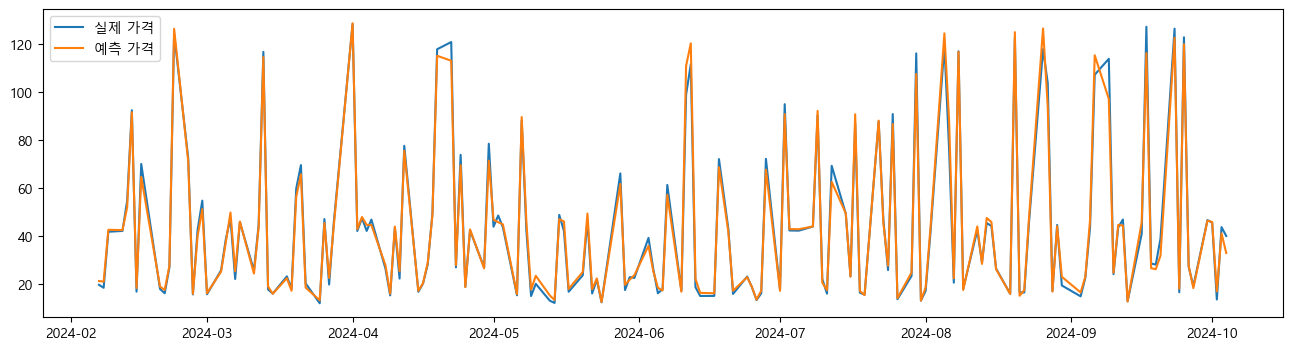

In [93]:
# 실제값과 예측값 시각화
plt.figure(figsize=(16,4))
plt.plot(nvda.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="실제 가격")
plt.plot(nvda.index[-len(predictions):], predictions, label="예측 가격")
plt.legend()
plt.show()

- 전체적으로 실제 가격과 예측 가격이 유사하므로 모델의 성능이 양호하다고 평가할 수 있음
- time_step을 90으로 했지만, 30이나 60으로 했을 때에도 비교해보면 좋을 것이라 판단